<Figure size 1200x1000 with 0 Axes>

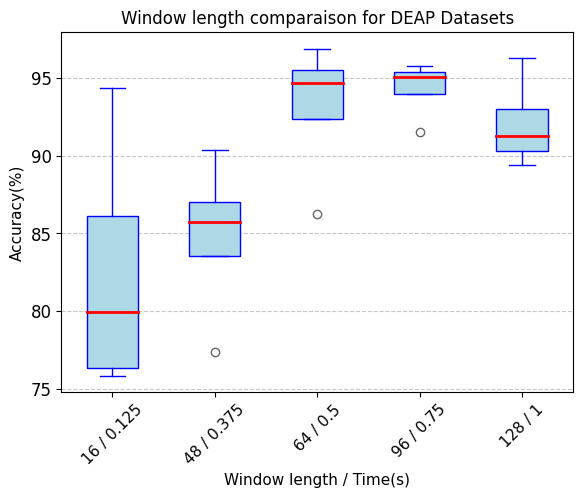

In [41]:
# 调整数据顺序，将窗长128放在最后
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 加载字体文件
simhei_font = FontProperties(fname='./SimHei.ttf')

# 创建数据框
data = {
    '被试': ['S01', 'S02', 'S03', 'S04'] * 5,
    '窗长': [16, 16, 16, 16, 48, 48, 48, 48, 64, 64, 64, 64, 96, 96, 96, 96, 128, 128, 128, 128],
    '时间长度（秒）': [0.125] * 4 + [0.375] * 4 + [0.5] * 4 + [0.75] * 4 + [1] * 4,
    'Accuracy(%)': [
        75.86, 76.56, 94.37, 83.36, 
        90.38, 85.61, 85.88, 77.36, 
        95.00, 96.87, 94.37, 86.25, 
        91.51, 95.74, 94.81, 95.24, 
        96.25, 89.37, 90.62, 91.87
    ],
    'Window length & Time(s)': ['16 / 0.125'] * 4 + ['48 / 0.375'] * 4 + ['64 / 0.5'] * 4 + ['96 / 0.75'] * 4 + ['128 / 1'] * 4
}

df = pd.DataFrame(data)

order = ['16 / 0.125', '48 / 0.375', '64 / 0.5', '96 / 0.75', '128 / 1']

# 将 "窗长 & 时间长度 (s)" 列转换为有序类别
df['Window length & Time(s)'] = pd.Categorical(df['Window length & Time(s)'], categories=order, ordered=True)

# 对数据进行排序
df = df.sort_values('Window length & Time(s)') 

plt.figure(figsize=(12, 10))
boxplot = df.boxplot(
    column='Accuracy(%)',
    by='Window length & Time(s)',
    grid=False,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    medianprops=dict(color='red', linewidth=2),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue'),
    flierprops=dict(marker='o', color='orange', alpha=0.6)
)

# 设置图表标签
plt.title('Window length comparaison for DEAP Datasets')
plt.suptitle('')
plt.xlabel('Window length / Time(s)', fontsize=11)
plt.ylabel('Accuracy(%)', fontsize=11)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 保存为 PDF 文件
plt.savefig('length_sorted.pdf', bbox_inches='tight', dpi=300)
plt.show()


Groups length: 150
Accuracy length: 150
DataFrame created successfully


<Figure size 1200x600 with 0 Axes>

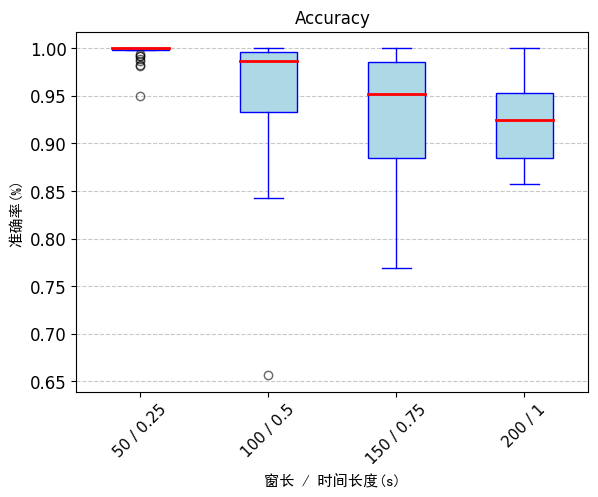

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.font_manager import FontProperties

simhei_font = FontProperties(fname='./SimHei.ttf')
# 准备数据，整理为长格式
groups = ['50 / 0.25'] * 37 + ['100 / 0.5'] * 44 + \
         ['150 / 0.75'] * 46 + ['200 / 1'] * 23

accuracy = [
    # 第一组
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
    0.997787610619469, 0.997787610619469, 1, 0.992256637168142, 
    0.988938053097345, 1, 0.993362831858407, 0.986725663716814,
    0.992256637168142, 1, 0.981194690265487, 0.982300884955752, 1, 
    1, 1, 0.997787610619469, 0.950221238938053, 1, 1, 0.998893805309734,
    # 第二组
    1, 1, 1, 1, 1, 1, 1, 0.997782705099778, 0.997782705099778, 0.997782705099778, 
    0.997782705099778, 0.995565410199557, 0.995565410199557, 0.993348115299335, 
    0.993348115299335, 0.993348115299335, 0.991130820399113, 0.991130820399113, 
    0.988913525498891, 0.988913525498891, 0.988913525498891, 0.98669623059867, 
    0.98669623059867, 0.98669623059867, 0.977827050997783, 0.964523281596452, 
    0.957871396895787, 0.953436807095344, 0.951219512195122, 0.9490022172949, 
    0.9490022172949, 0.93569844789357, 0.933481152993348, 0.933481152993348, 
    0.929046563192905, 0.929046563192905, 0.924611973392461, 0.922394678492239, 
    0.911308203991131, 0.891352549889135, 0.858093126385809, 0.851441241685144, 
    0.842572062084257, 0.656319290465632,
    # 第三组
    1, 1, 1, 1, 0.996655518394649, 0.996655518394649, 0.996655518394649, 
    0.996655518394649, 0.993311036789298, 0.989966555183946, 0.986622073578595, 
    0.983277591973244, 0.979933110367893, 0.979933110367893, 0.973244147157191, 
    0.96989966555184, 0.96989966555184, 0.96989966555184, 0.96989966555184, 
    0.966555183946488, 0.953177257525084, 0.953177257525084, 0.949832775919732, 
    0.939799331103679, 0.939799331103679, 0.933110367892977, 0.926421404682274, 
    0.923076923076923, 0.919732441471572, 0.91304347826087, 0.91304347826087, 
    0.906354515050167, 0.899665551839465, 0.879598662207358, 0.869565217391304, 
    0.866220735785953, 0.8561872909699, 0.842809364548495, 0.842809364548495, 
    0.822742474916388, 0.809364548494983, 0.806020066889632, 0.79933110367893, 
    0.77257525083612, 0.769230769230769,
    # 第四组
    1, 1, 0.991111111111111, 0.986666666666667, 0.977777777777778, 
    0.96, 0.96, 0.946666666666667, 0.937777777777778, 0.928888888888889, 
    0.928888888888889, 0.928888888888889, 0.924444444444444, 0.92, 
    0.915555555555556, 0.911111111111111, 0.906666666666667, 0.888888888888889, 
    0.88, 0.875555555555556, 0.875555555555556, 0.871111111111111, 
    0.866666666666667, 0.857777777777778
]

# 检查两列的长度
print("Groups length:", len(groups))
print("Accuracy length:", len(accuracy))

# 如果长度不匹配，将提示用户修复
if len(groups) != len(accuracy):
    raise ValueError("The lengths of 'groups' and 'accuracy' do not match!")

# 转换为 DataFrame
df = pd.DataFrame({'Group': groups, 'Accuracy': accuracy})
print("DataFrame created successfully")
order = ['50 / 0.25'] + ['100 / 0.5']+ ['150 / 0.75']+['200 / 1'] 

# 将 "窗长 & 时间长度 (s)" 列转换为有序类别
df['Group'] = pd.Categorical(df['Group'], categories=order, ordered=True)


plt.figure(figsize=(12, 6))
df.boxplot(column='Accuracy', by='Group', grid=False, patch_artist=True,
           boxprops=dict(facecolor='lightblue', color='blue'),
           medianprops=dict(color='red', linewidth=2),
           whiskerprops=dict(color='blue'),
           capprops=dict(color='blue'),
           flierprops=dict(marker='o', color='orange', alpha=0.6))

# 设置图表标题和标签
# plt.title('Window length comparaison for SEED Datasets')
plt.suptitle('')
plt.xlabel('窗长 / 时间长度(s)', fontsize=11, fontproperties=simhei_font)
plt.ylabel('准确率(%)', fontsize=11, fontproperties=simhei_font)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('length_seed.pdf', bbox_inches='tight', dpi=300)

plt.show()


In [1]:
import numpy as np

data = np.load('/data/Anaiis/Data/Data/SEED/len_200/smooth_False/7_20131030/de.npy')
# data = np.load('../Effect_Att/Data/len_96/False/s13/data.npy')
# label = np.load('../Effect_Att/Data/len_96/False/s13/label.npy')

print(data.shape)

(3394, 62, 5)


In [5]:
import os
import numpy as np

# 定义数据集的路径
base_path = "../Effect_Att/Data/len_96/False"

# 初始化空列表，用于存储数据和标签
data_list = []
label_list = []

# 遍历文件夹
for i in range(1, 33):  # 从 01 到 32
    folder_name = f"s{i:02d}"  # 格式化为两位数字，前面补零
    folder_path = os.path.join(base_path, folder_name)
    
    data_file = os.path.join(folder_path, "data.npy")
    label_file = os.path.join(folder_path, "label.npy")
    
    # 检查文件是否存在
    if os.path.exists(data_file) and os.path.exists(label_file):
        data = np.load(data_file)
        label = np.load(label_file)
        
        data_list.append(data)
        label_list.append(label)
    else:
        print(f"文件 {data_file} 或 {label_file} 不存在")

# 将列表中的数据和标签沿第0维度拼接在一起
all_data = np.concatenate(data_list, axis=0)
all_labels = np.concatenate(label_list, axis=0)

# 打印拼接后的形状
print(f"All data shape: {all_data.shape}")
print(f"All labels shape: {all_labels.shape}")


All data shape: (102400, 32, 4, 96)
All labels shape: (102400,)


In [8]:
np.save("../Effect_Att/Data/len_96/False/all/label.npy", all_labels)

Pooled Node Features:
 tensor([[5.9894, 6.9876],
        [4.9788, 5.9746],
        [3.9595, 4.9494]], grad_fn=<MulBackward0>)


/home/micro/anaconda3/envs/bob_env1/lib/python3.8/site-packages/torch_geometric/data/storage.py:450: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


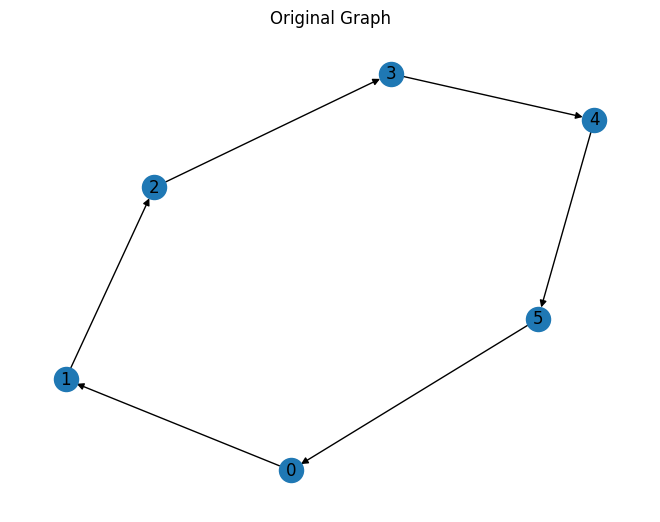

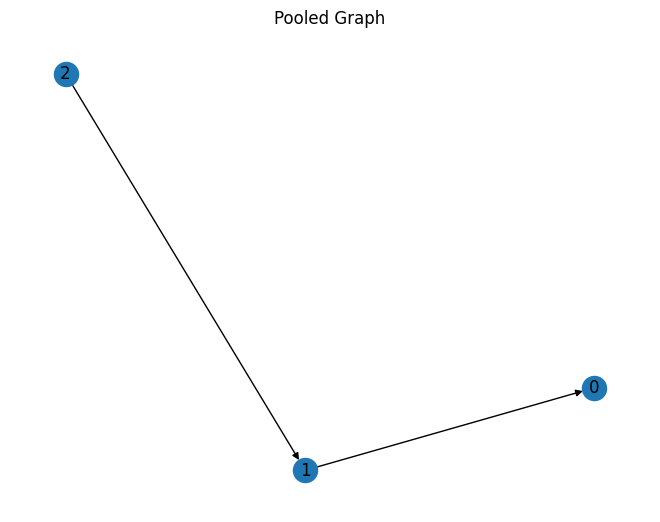

In [6]:
import torch
from torch_geometric.nn import TopKPooling
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

# 创建一个图数据，其中包含 6 个节点和边
x = torch.tensor([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7]], dtype=torch.float)  # 节点特征
edge_index = torch.tensor([[0, 1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 0]], dtype=torch.long)  # 边列表

# 构建图数据
data = Data(x=x, edge_index=edge_index)

# 初始化 TopKPooling，保持 50% 的节点
pool = TopKPooling(in_channels=x.size(1), ratio=0.5)

# 应用 Top-K Pooling
x_pooled, edge_index_pooled, _, batch, _, _= pool(x, edge_index)

print("Pooled Node Features:\n", x_pooled)
# print("Pooled Edge Index:\n", edge_index_pooled)

# 可视化原始图和池化后的图
def plot_graph(edge_index, title):
    G = to_networkx(Data(edge_index=edge_index))
    nx.draw(G, with_labels=True)
    plt.title(title)
    plt.show()

plot_graph(edge_index, "Original Graph")
plot_graph(edge_index_pooled, "Pooled Graph")


# 可视化第二层GAT后的数据


In [2]:
import torch
i = 0 
attn_weight = torch.load(f'./vis_data/attn_weight_{i}.pt')
edge_index = torch.load(f'./vis_data/edge_index_{i}.pt')
label = torch.load(f'./vis_data/labels_0.pt')

In [24]:
label

tensor([1], device='cuda:1')

In [25]:
label = torch.load(f'./vis_data/labels_6.pt')
label

tensor([2], device='cuda:1')

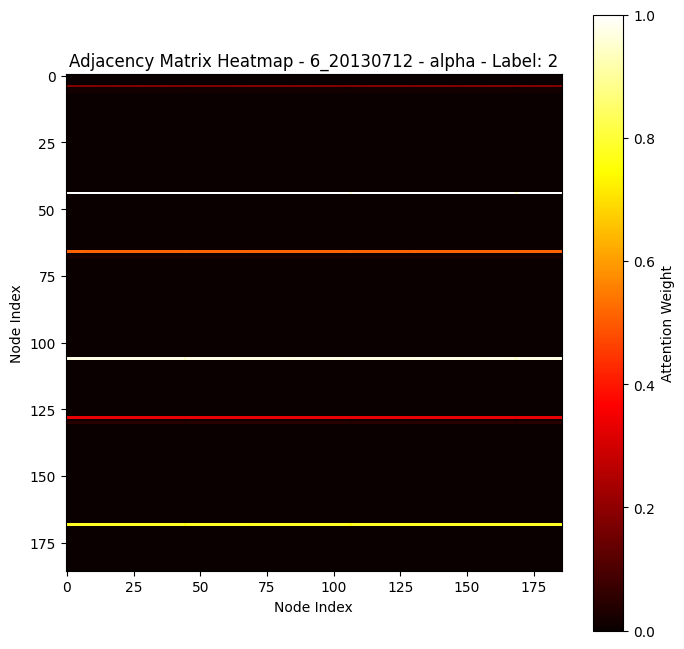

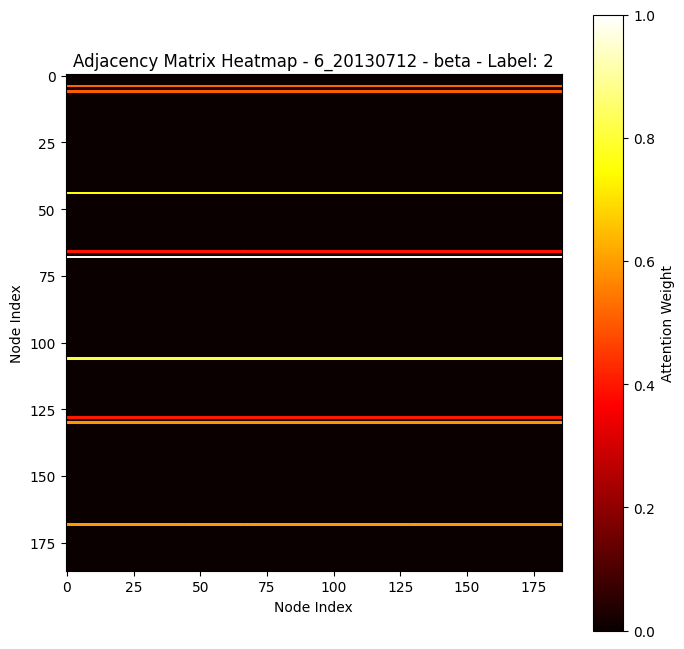

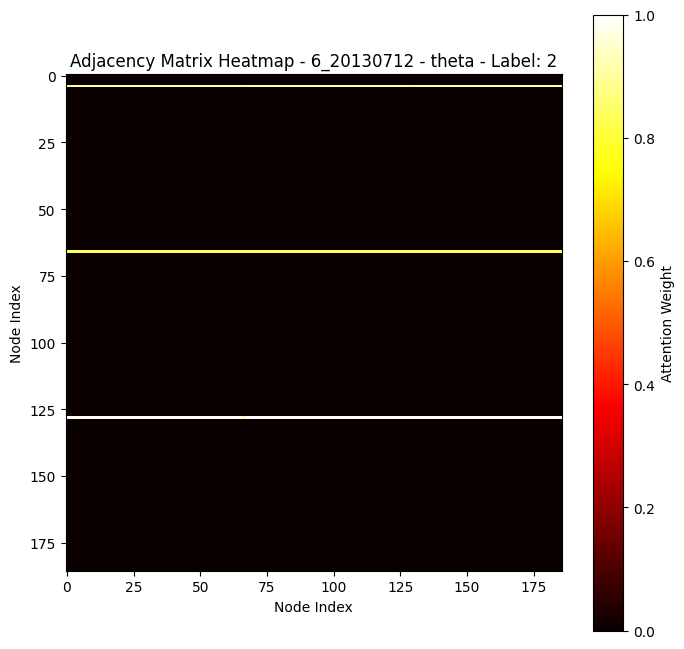

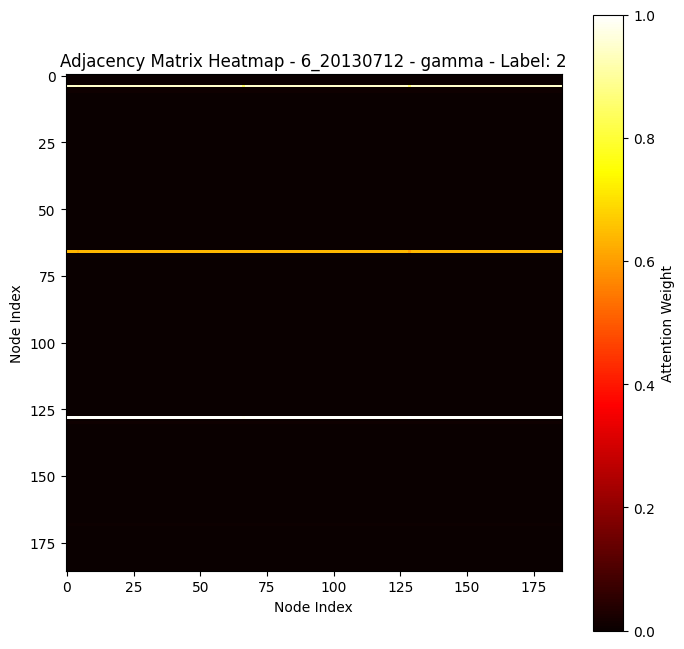

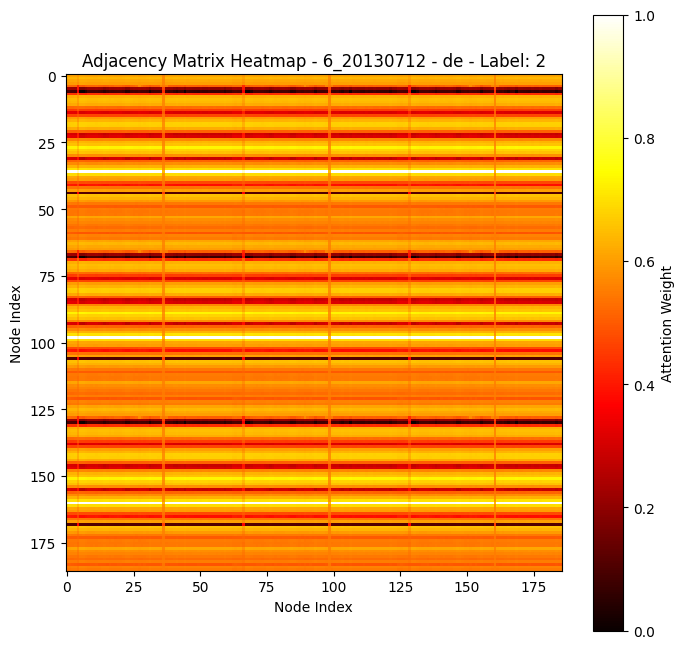

In [28]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


bands = ["alpha", "beta", "theta", "gamma", "de"]
selec_lab = 2
person = '6_20130712'
for band in bands:
    cnt = 0
    edge_index_np = None
    attention_weights_np = None 
    for n in range(225):
    # 加载注意力权重和 edge_index
        attention_weights = torch.load(f'/data/Anaiis/garage/vis_data/{person}/attn_weight_l1{band}_{n}.pt')
        edge_index = torch.load(f'/data/Anaiis/garage/vis_data/{person}/edge_index_l1gamma_{n}.pt')
        label = torch.load(f'/data/Anaiis/garage/vis_data/{person}/labels_{n}.pt').item()
        if label == selec_lab :
            # 将 edge_index 和 attention_weights 转换为 NumPy 数组
            if cnt == 0:
                edge_index_np = edge_index.cpu().numpy()
                attention_weights_np = attention_weights.cpu().numpy().squeeze()
                cnt += 1
            else:
                attention_weights_np += attention_weights.cpu().numpy().squeeze()
    


    num_nodes = edge_index_np.max() + 1  # 假设节点编号是从0开始的

    # 创建一个空的邻接矩阵
    adj_matrix = np.zeros((num_nodes, num_nodes))

    # 使用 edge_index 和 attention_weights 填充邻接矩阵
    for idx in range(edge_index_np.shape[1]):
        i, j = edge_index_np[:, idx]
        adj_matrix[i, j] = attention_weights_np[idx].mean()
    adj_matrix_normalized = (adj_matrix - adj_matrix.min()) / (adj_matrix.max() - adj_matrix.min())

    # 绘制邻接矩阵的热力图
    plt.figure(figsize=(8, 8))
    plt.title(f"Adjacency Matrix Heatmap - {person} - {band} - Label: {selec_lab}")
    plt.imshow(adj_matrix_normalized, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Attention Weight')
    plt.xlabel('Node Index')
    plt.ylabel('Node Index')
    plt.savefig(f'/data/Anaiis/garage/figs/seed_label{selec_lab}/{person}/avg_{band}_fig')
    plt.show()
    # 计算每个边的平均注意力权重（如果有多个头部）
    # attention_weights_np = attention_weights_np.mean(axis=1)

    # # 创建一个无向图
    # G = nx.Graph()

    # # 假设节点编号从0开始连续编号
    # num_nodes = edge_index.max().item() + 1
    # G.add_nodes_from(range(num_nodes))

    # 添加边及其权重
    # for i in range(edge_index_np.shape[1]):
    #     src = edge_index_np[0, i]
    #     dst = edge_index_np[1, i]
    #     weight = attention_weights_np[i]
    #     G.add_edge(src, dst, weight=weight)

    # # 计算每个节点的总连接强度（即所有相连边的权重之和）
    # node_strength = {node: 0.0 for node in G.nodes()}
    # for (u, v, d) in G.edges(data=True):
    #     node_strength[u] += d['weight']
    #     node_strength[v] += d['weight']

    # # 固定节点位置
    # pos = nx.spring_layout(G, seed=42)  # 固定布局

    # # 将节点强度转换为颜色值（归一化到 [0, 1]）
    # node_colors = np.array(list(node_strength.values()))
    # node_colors_normalized = (node_colors - node_colors.min()) / (node_colors.max() - node_colors.min())
    # cmap = plt.cm.viridis

    # # 绘制图形
    # plt.figure(figsize=(10, 7))
    # nx.draw_networkx_nodes(G, pos, node_color=node_colors_normalized, node_size=500, cmap=cmap)
    # weights = [d['weight'] for (u, v, d) in G.edges(data=True)]
    # nx.draw_networkx_edges(G, pos, width=1, edge_color='grey', alpha=0.5)
    # nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')

    # sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=node_colors.min(), vmax=node_colors.max()))
    # sm.set_array([])
    # plt.colorbar(sm, label='Node Connection Strength')

    # plt.title('EEG Graph Visualization with Attention Weights')
    # # plt.show()
    # plt.savefig(f'/data/Anaiis/garage/figs/seed_label{label}/7_20131030/theta_fig_{n}')
    


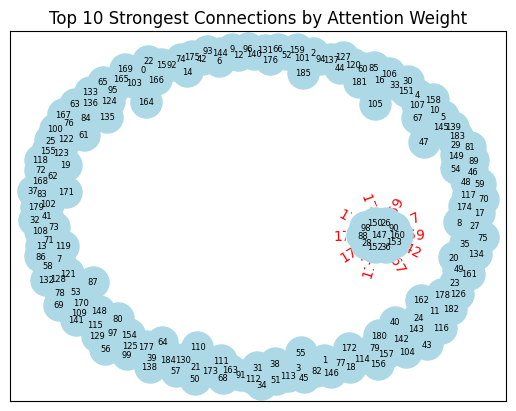

In [ ]:
# 获取前10个最大权重的边索引
top_k = 10
top_indices = attention_weights_np.argsort()[-top_k:][::-1]  # 从大到小排序

top_edges = [(edge_index_np[0, i], edge_index_np[1, i]) for i in top_indices]
top_weights = [attention_weights_np[i] for i in top_indices]

# 创建一个新的图，仅包含前10条边
G_top = nx.Graph()
G_top.add_nodes_from(range(edge_index.max().item() + 1))
for (src, dst), weight in zip(top_edges, top_weights):
    G_top.add_edge(src, dst, weight=weight)

# 生成节点的布局
pos = nx.spring_layout(G_top)

# 绘制节点
nx.draw_networkx_nodes(G_top, pos, node_color='lightblue', node_size=500)

# 绘制带有颜色和宽度的边
edge_widths = [weight * 5 for weight in top_weights]
edge_colors = [plt.cm.Blues((weight - min(top_weights)) / (max(top_weights) - min(top_weights))) for weight in top_weights]
nx.draw_networkx_edges(G_top, pos, width=edge_widths, edge_color=edge_colors)

# 绘制边的权重标签
edge_labels = {(src, dst): f'{weight*10000:.4f}' for (src, dst), weight in zip(top_edges, top_weights)}
nx.draw_networkx_edge_labels(G_top, pos, edge_labels=edge_labels, font_color='red')

# 绘制节点标签
nx.draw_networkx_labels(G_top, pos, font_size=6, font_color='black')

plt.title("Top 10 Strongest Connections by Attention Weight")
plt.show()

In [32]:
len(set(attention_weights_np))

34527

In [34]:
(attention_weights.shape)

torch.Size([34596, 1])

上一part结论：attn weight拉不开差距，要不显示特征试试？头皮图

In [21]:
for i in range(20, 30):
    attn_weight = torch.load(f'./vis_data/afterconv_de_{i}.pt')
    print("true label:", torch.load(f'./vis_data/labels_{i}.pt').item())
    attn_weight[:, 0].shape
    feat0 =  attn_weight[:, 0]
    # feat0.reshape((62, 3))
    print("feat0", feat0.unique())
    print("feat1", attn_weight[:, 1].unique())
    print("feat2", attn_weight[:, 2].unique())

true label: 2
feat0 tensor([11.6312, 11.6312, 11.6312, 11.6312, 11.6312, 11.6312, 11.6312, 11.6312,
        11.6312, 11.6312, 11.6312, 11.6312, 11.6312], device='cuda:1')
feat1 tensor([2.6715, 2.6715, 2.6715, 2.6715, 2.6715, 2.6715, 2.6715, 2.6715, 2.6715],
       device='cuda:1')
feat2 tensor([48.7491, 48.7492, 48.7492, 48.7492, 48.7492, 48.7492, 48.7492, 48.7492,
        48.7492, 48.7492, 48.7492, 48.7492, 48.7492, 48.7492, 48.7492, 48.7492,
        48.7492], device='cuda:1')
true label: 1
feat0 tensor([-0.0022, -0.0022, -0.0022, -0.0022, -0.0022, -0.0022, -0.0022, -0.0022,
        -0.0022, -0.0022], device='cuda:1')
feat1 tensor([20.0898, 20.0898, 20.0898, 20.0898, 20.0898, 20.0898, 20.0898, 20.0898,
        20.0899, 20.0899], device='cuda:1')
feat2 tensor([0.2720, 0.2720, 0.2720, 0.2720, 0.2720, 0.2720, 0.2720, 0.2720],
       device='cuda:1')
true label: 2
feat0 tensor([2.4551, 2.4551, 2.4551, 2.4551, 2.4551, 2.4551, 2.4551, 2.4551, 2.4551],
       device='cuda:1')
feat1 tensor([6

两次图卷积后的特征收敛到一个数值周围，所有节点都在这个数周围（单看每张图，三个标签收敛到的数值有巨大差异，很容易分类），但是是什么时候收敛到的呢，什么导致了这个收敛呢？

gamma_feats (186, 512)
(62, 512)
[[4.8309536  5.0919113  4.441053   ... 4.037175   1.2253034  0.76773596]
 [4.8309536  5.0919113  4.441053   ... 4.037169   1.2253009  0.76773405]
 [4.8309536  5.0919113  4.441053   ... 4.0371776  1.2253042  0.76773655]
 ...
 [4.830953   5.091911   4.441052   ... 4.0373716  1.2253809  0.7677946 ]
 [4.830953   5.091911   4.441052   ... 4.037307   1.2253551  0.76777506]
 [4.830953   5.091911   4.441052   ... 4.0373297  1.2253642  0.76778185]]
[2.11241675 2.11078334 2.1112201  2.10938369 2.11210961 2.02927362
 2.12735721 2.1266943  2.10788543 2.1088382  2.10956122 2.11112908
 2.11603904 2.11749661 2.12117819 2.1177589  2.11761842 2.11169495
 2.10908706 2.10758359 2.11327649 2.1159617  2.11834731 2.11810919
 2.11838334 2.11701971 2.11392244 2.11052657 2.10895088 2.11124132
 2.11778942 2.11955436 2.12119795 2.11803698 2.11866683 2.11507853
 2.11148899 2.11710887 2.11826419 2.11779437 2.11889904 2.11761673
 2.11956822 2.11967044 1.94283387 2.11863552 2.1205988

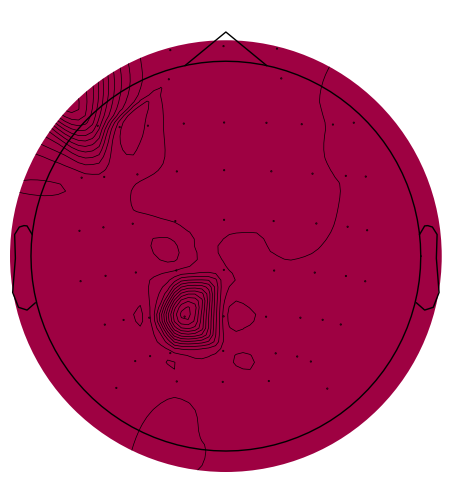

In [3]:
import mne
import torch
import numpy as np
import matplotlib.pyplot as plt


i=10
gamma_feats = torch.load(f'/data/Anaiis/garage/vis_data/6_20130712/beta_feats_{i}.pt')
gamma_feats = gamma_feats.cpu().numpy()
print("gamma_feats", gamma_feats.shape)
gamma_feats = gamma_feats.reshape((3, 62, -1))

n_channels = 62
sfreq = 256
n_times = 1
data = gamma_feats[1, :, :].squeeze()
print(data.shape)
print(data)
# 设置通道名称（假设使用国际10-20系统的标准名称）
biosemi_montage = mne.channels.make_standard_montage('standard_1020')
# print(biosemi_montage.ch_names, biosemi_montage)
channel_names = [
    'Fp1', 'Fpz', 'Fp2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8',
    'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz',
    'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'P7',
    'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POz', 'PO4', 'PO6', 
    'PO8', 'PO9', 'O1', 'Oz', 'O2', 'PO10'
]
info = mne.create_info(ch_names=channel_names, sfreq=128, ch_types='eeg')
evoked = mne.EvokedArray(data, info)
evoked.set_montage(biosemi_montage)
fig, ax = plt.subplots(1, 1, figsize=(6, 6)) 
print(np.mean(evoked.data, axis=1))
mne.viz.plot_topomap(np.mean(evoked.data, axis=1), evoked.info, show=False, 
                    ch_type='eeg', cmap='Spectral_r', contours=15, axes=ax, vlim=(0.1, 0.5))#vlim=(vmin, vmax),
plt.show()

## 画2d带位置的attn weight图

In [3]:
import pandas as pd

file_path = './channel-order.xlsx'
sheet1_df = pd.read_excel(file_path, sheet_name='Sheet1', header=None)

channel_index_dict = {idx: channel_name for idx, channel_name in enumerate(sheet1_df.iloc[:, 0])}

channel_index_dict

{0: 'Fp1',
 1: 'Fpz',
 2: 'Fp2',
 3: 'AF3',
 4: 'AF4',
 5: 'F7',
 6: 'F5',
 7: 'F3',
 8: 'F1',
 9: 'Fz',
 10: 'F2',
 11: 'F4',
 12: 'F6',
 13: 'F8',
 14: 'FT7',
 15: 'FC5',
 16: 'FC3',
 17: 'FC1',
 18: 'FCz',
 19: 'FC2',
 20: 'FC4',
 21: 'FC6',
 22: 'FT8',
 23: 'T7',
 24: 'C5',
 25: 'C3',
 26: 'C1',
 27: 'Cz',
 28: 'C2',
 29: 'C4',
 30: 'C6',
 31: 'T8',
 32: 'TP7',
 33: 'CP5',
 34: 'CP3',
 35: 'CP1',
 36: 'CPz',
 37: 'CP2',
 38: 'CP4',
 39: 'CP6',
 40: 'TP8',
 41: 'P7',
 42: 'P5',
 43: 'P3',
 44: 'P1',
 45: 'Pz',
 46: 'P2',
 47: 'P4',
 48: 'P6',
 49: 'P8',
 50: 'PO7',
 51: 'PO5',
 52: 'PO3',
 53: 'POz',
 54: 'PO4',
 55: 'PO6',
 56: 'PO8',
 57: 'CB1',
 58: 'O1',
 59: 'Oz',
 60: 'O2',
 61: 'CB2'}

In [5]:
channel_name_list = list(channel_index_dict.values())

In [27]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import mne

builtin_montages = mne.channels.get_builtin_montages(descriptions=True)
for montage_name, montage_description in builtin_montages:
    print(f"{montage_name}: {montage_description}")

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 64 channels>


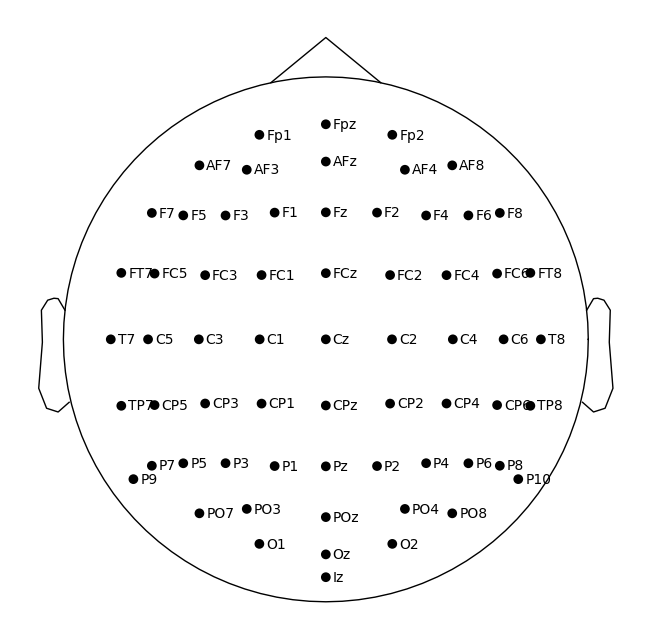

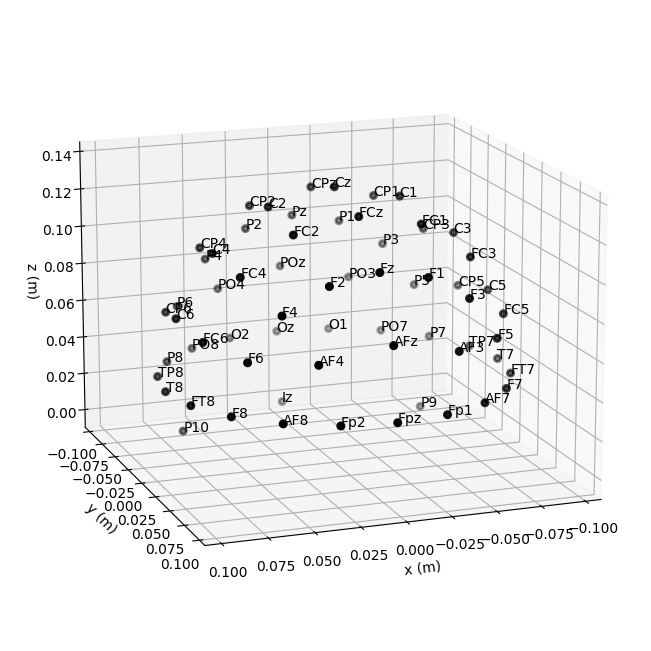

In [29]:
easycap_montage = mne.channels.make_standard_montage("biosemi64")
easycap_montage.plot()  # 2D
fig = easycap_montage.plot(kind="3d", show=False)  # 3D
fig = fig.gca().view_init(azim=70, elev=15)  # set view angle for tutorial

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import torch

# 假设有你的连接程度数组
degree_array = np.random.rand(62)  # 连接程度的示例数据

bands = ["alpha", "beta", "theta", "gamma", "de"]
selec_lab = 1
person = '6_20130712'
# for band in bands:
band = "gamma"
cnt = 0
edge_index_np = None
attention_weights_np = None 
for n in range(225):
# 加载注意力权重和 edge_index
    attention_weights = torch.load(f'/data/Anaiis/garage/vis_data/{person}/attn_weight_l1{band}_{n}.pt')
    edge_index = torch.load(f'/data/Anaiis/garage/vis_data/{person}/edge_index_l1gamma_{n}.pt')
    label = torch.load(f'/data/Anaiis/garage/vis_data/{person}/labels_{n}.pt').item()
    if label == selec_lab :
        # 将 edge_index 和 attention_weights 转换为 NumPy 数组
        if cnt == 0:
            edge_index_np = edge_index.cpu().numpy()
            attention_weights_np = attention_weights.cpu().numpy().squeeze()
            cnt += 1
        else:
            attention_weights_np += attention_weights.cpu().numpy().squeeze()
num_nodes = edge_index_np.max() + 1  # 假设节点编号是从0开始的

# 创建一个空的邻接矩阵
adj_matrix = np.zeros((num_nodes, num_nodes))

# 使用 edge_index 和 attention_weights 填充邻接矩阵
for idx in range(edge_index_np.shape[1]):
    i, j = edge_index_np[:, idx]
    adj_matrix[i, j] = attention_weights_np[idx].mean()
adj_matrix_normalized = (adj_matrix - adj_matrix.min()) / (adj_matrix.max() - adj_matrix.min())

print(adj_matrix_normalized.shape)
adj_matrix_normalized_t0 = adj_matrix_normalized[0:62, :]

(186, 186)


In [6]:
channels_to_remove = ['PO5', 'PO6', 'CB1', 'CB2']
indices_to_remove = []
for chan in channels_to_remove:
    index = channel_name_list.index(chan)
    indices_to_remove.append(index)
print(indices_to_remove)
adj_matrix_normalized_t0_f = np.delete(adj_matrix_normalized_t0, indices_to_remove, axis=0)
print(adj_matrix_normalized_t0_f.shape)


[51, 55, 57, 61]
(58, 186)


In [9]:
channel_name_list = np.delete(channel_name_list, indices_to_remove, axis=0)

Creating RawArray with float64 data, n_channels=58, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


/tmp/ipykernel_2809138/416851761.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


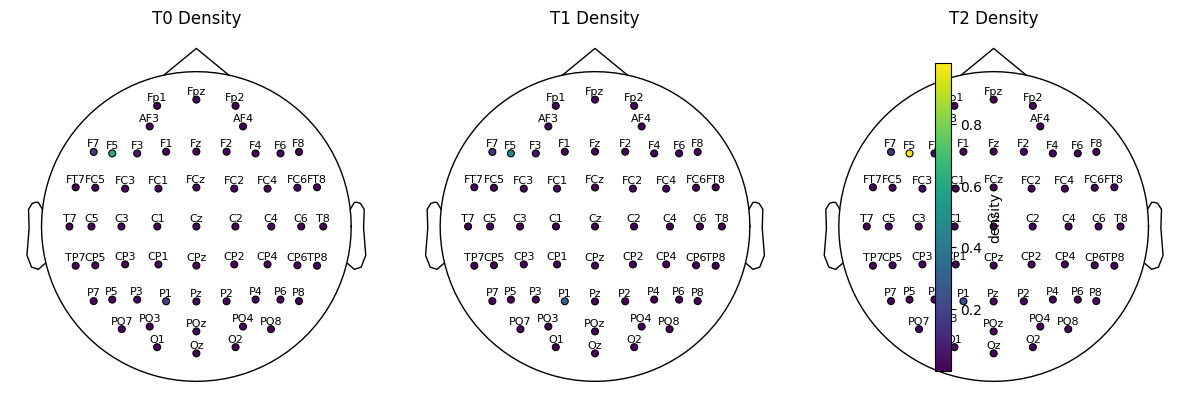

In [10]:
montage = mne.channels.make_standard_montage('biosemi64')
# print(biosemi_montage.ch_names, biosemi_montage)
channels = list(channel_name_list)
info = mne.create_info(ch_names=channels, sfreq=1, ch_types='eeg')
info.set_montage(montage)

data = np.zeros((58, 1))

raw = mne.io.RawArray(data, info)

all_degrees  = adj_matrix_normalized.mean(axis = 1)
norm = Normalize(vmin=np.min(all_degrees), vmax=np.max(all_degrees))

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# 定义三个时间点的 degree_array 和各自的 axes
degree_arrays = [all_degrees[:62], all_degrees[62:124], all_degrees[124:]]
titles = ['T0 Density', 'T1 Density', 'T2 Density']

# 循环绘制每个图
for i, (degree_array, ax) in enumerate(zip(degree_arrays, axes)):
    raw.plot_sensors(ch_type="eeg", axes=ax, show=False)
    sensor_points = ax.collections[0]
    positions = sensor_points.get_offsets()

    # 设置颜色
    colors = [plt.cm.viridis(norm(degree_array[i])) for i in range(58)]
    sensor_points.set_facecolors(colors)
    sensor_points.set_edgecolors('k')
    sensor_points.set_linewidths(0.8)

    # 显示通道名称
    for j, ch_name in enumerate(channels):
        ax.text(positions[j, 0], positions[j, 1] + 0.005, ch_name, fontsize=8, ha='center', va='center')

    # 添加标题
    ax.set_title(titles[i])

# 在右侧添加一个共享的颜色条
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=axes, orientation='vertical', label="density")

# 调整布局并显示图像
plt.tight_layout()
plt.show()


In [17]:
import mne
import matplotlib.pyplot as plt

# 定义32导的通道名称
channel_names = channels = ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5',
    'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8',
    'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2',
    'Fz', 'Cz']

# 创建一个标准的64导电极布置
montage_full = mne.channels.make_standard_montage('standard_1020')

# 选择32个通道并构建新的位置信息
ch_pos = {ch: montage_full._get_ch_pos()[ch] for ch in channel_names}

# 创建新的DigMontage
montage_32 = mne.channels.make_dig_montage(ch_pos=ch_pos)

# 绘制电极位置图
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
mne.viz.plot_montage(montage_32, kind='topomap', show=False, axes=ax, sphere=(0.01, -0.01, 0, 0.12))

# # 去掉背景
# fig.patch.set_alpha(0)  
# ax.set_facecolor("none")

# 保存为无背景的图片
fig.savefig("32_channel_eeg_montage.png", format="png",dpi=300)

plt.close(fig)


/tmp/ipykernel_3824602/1416569253.py:22: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne.viz.plot_montage(montage_32, kind='topomap', show=False, axes=ax, sphere=(0.01, -0.01, 0, 0.12))


In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# 假设有你的数据
montage = mne.channels.make_standard_montage('biosemi64')
channels = list(channel_name_list)
info = mne.create_info(ch_names=channels, sfreq=1, ch_types='eeg')
info.set_montage(montage)

data = np.zeros((58, 1))
raw = mne.io.RawArray(data, info)

all_degrees = adj_matrix_normalized.mean(axis=1)
norm = Normalize(vmin=np.min(all_degrees), vmax=np.max(all_degrees))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 定义三个时间点的 degree_array 和各自的 axes
degree_arrays = [all_degrees[:62], all_degrees[62:124], all_degrees[124:]]
titles = ['T0 Density', 'T1 Density', 'T2 Density']

# 循环绘制每个图
for i, (degree_array, ax) in enumerate(zip(degree_arrays, axes)):
    # 使用统一的颜色映射
    raw.plot_sensors(ch_type="eeg", axes=ax, show=False)
    sensor_points = ax.collections[0]
    positions = sensor_points.get_offsets()

    # 设置颜色
    colors = [plt.cm.viridis(norm(degree_array[i])) for i in range(58)]
    sensor_points.set_facecolors(colors)
    sensor_points.set_edgecolors('k')
    sensor_points.set_linewidths(0.8)

    # 设置节点大小（加大点大小）
    sensor_points.set_sizes([200] * len(positions))  # 200 是调整后的大小，可以根据需要增减

    # 显示通道名称
    for j, ch_name in enumerate(channels):
        ax.text(positions[j, 0], positions[j, 1] + 0.008, ch_name, fontsize=8, ha='center', va='center')

    # 添加标题
    ax.set_title(titles[i])

# 在右侧添加一个共享的颜色条
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

# 调整子图布局，确保colorbar不会与图片重叠
fig.subplots_adjust(right=0.85)  # 为colorbar预留空间，右侧留出15%的宽度

# 将 colorbar 放在右侧
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(sm, cax=cbar_ax, label="density")

# 调整布局并显示图像
plt.tight_layout(rect=[0, 0, 0.85, 1])  # 保证子图不被重叠
plt.show()


NameError: name 'channel_name_list' is not defined

### confusion matrix

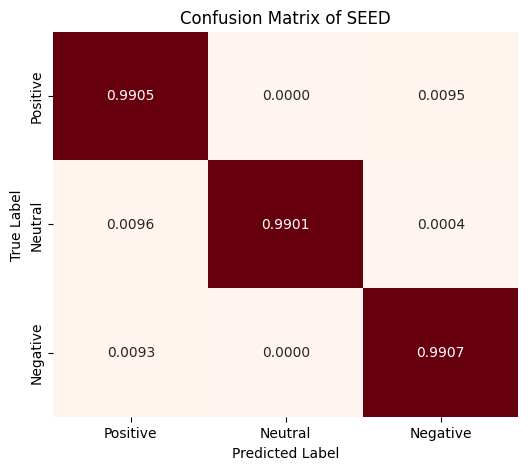

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.font_manager import FontProperties

simhei_font = FontProperties(fname='./SimHei.ttf')
# 示例数据，应替换为你的实际混淆矩阵数据
cm = np.array([
    [1502.72,  0.0,   14.36],
    [  13.85, 1435.4,   0.51],
    [ 14.36,  0.0, 1535.79]
])
cm_normalized = cm / cm.sum(axis=1, keepdims=True)

# 设置标签
labels = ['Positive', 'Neutral', 'Negative']

# 创建热图
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".4f", cmap="Reds", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix of SEED')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix_seed.pdf')
plt.show()


## topomap

In [60]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
biosemi_montage = mne.channels.make_standard_montage('biosemi64')
file_path = './channel-order.xlsx'
sheet1_df = pd.read_excel(file_path, sheet_name='Sheet1', header=None)
channel_index_dict = {idx: channel_name for idx, channel_name in enumerate(sheet1_df.iloc[:, 0])}
channel_name_list = list(channel_index_dict.values())

channels_to_remove = ['PO5', 'PO6', 'CB1', 'CB2']
indices_to_remove = []
for chan in channels_to_remove:
    index = channel_name_list.index(chan)
    indices_to_remove.append(index)
channel_name_list = np.delete(channel_name_list, indices_to_remove, axis=0)
print(channel_name_list)



['Fp1' 'Fpz' 'Fp2' 'AF3' 'AF4' 'F7' 'F5' 'F3' 'F1' 'Fz' 'F2' 'F4' 'F6'
 'F8' 'FT7' 'FC5' 'FC3' 'FC1' 'FCz' 'FC2' 'FC4' 'FC6' 'FT8' 'T7' 'C5' 'C3'
 'C1' 'Cz' 'C2' 'C4' 'C6' 'T8' 'TP7' 'CP5' 'CP3' 'CP1' 'CPz' 'CP2' 'CP4'
 'CP6' 'TP8' 'P7' 'P5' 'P3' 'P1' 'Pz' 'P2' 'P4' 'P6' 'P8' 'PO7' 'PO3'
 'POz' 'PO4' 'PO8' 'O1' 'Oz' 'O2']


In [61]:
channel_name_list = list(channel_name_list)

In [64]:
bands = ["alpha", "beta", "theta", "gamma", "de"]
selec_lab = 0
person = '6_20131113'
# for band in bands:
band = "alpha"
cnt = 0
edge_index_np = None
attention_weights_np = None 
for n in range(225):
    attention_weights = torch.load(f'/data/Anaiis/garage/vis_data/{person}/attn_weight_l1{band}_{n}.pt')
    edge_index = torch.load(f'/data/Anaiis/garage/vis_data/{person}/edge_index_l1_{n}.pt')
    label = torch.load(f'/data/Anaiis/garage/vis_data/{person}/labels_{n}.pt').item()
    if label == selec_lab :
        # 将 edge_index 和 attention_weights 转换为 NumPy 数组
        if cnt == 0:
            edge_index_np = edge_index.cpu().numpy()
            attention_weights_np = attention_weights.cpu().numpy().squeeze()
            cnt += 1
        else:
            attention_weights_np += attention_weights.cpu().numpy().squeeze()
num_nodes = edge_index_np.max() + 1  # 节点个数
adj_matrix = np.zeros((num_nodes, num_nodes))

for idx in range(edge_index_np.shape[1]):
    i, j = edge_index_np[:, idx]
    adj_matrix[i, j] = attention_weights_np[idx].mean()

degrees = adj_matrix.mean(axis = 1)

degrees = degrees.reshape((-1, 62))
print(degrees.shape)
degrees_selected_chans = np.zeros((3, 58))
for t in range(3):
    degrees_selected_chans[t] = np.delete(degrees[t], indices_to_remove, axis=0)

print("shape after remove: ", degrees_selected_chans.shape)

scaler = MinMaxScaler()
degrees_minmax = scaler.fit_transform(degrees_selected_chans)

# Log Normalization (加1以避免 log(0))
degrees_log = np.log(degrees_selected_chans + 1)

# Standard (Z-score) Normalization
degrees_std = (degrees_selected_chans - np.mean(degrees_selected_chans, axis=0)) / np.std(degrees_selected_chans, axis=0)



(3, 62)
shape after remove:  (3, 58)


/tmp/ipykernel_1670172/3938238248.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # 保证子图不被重叠


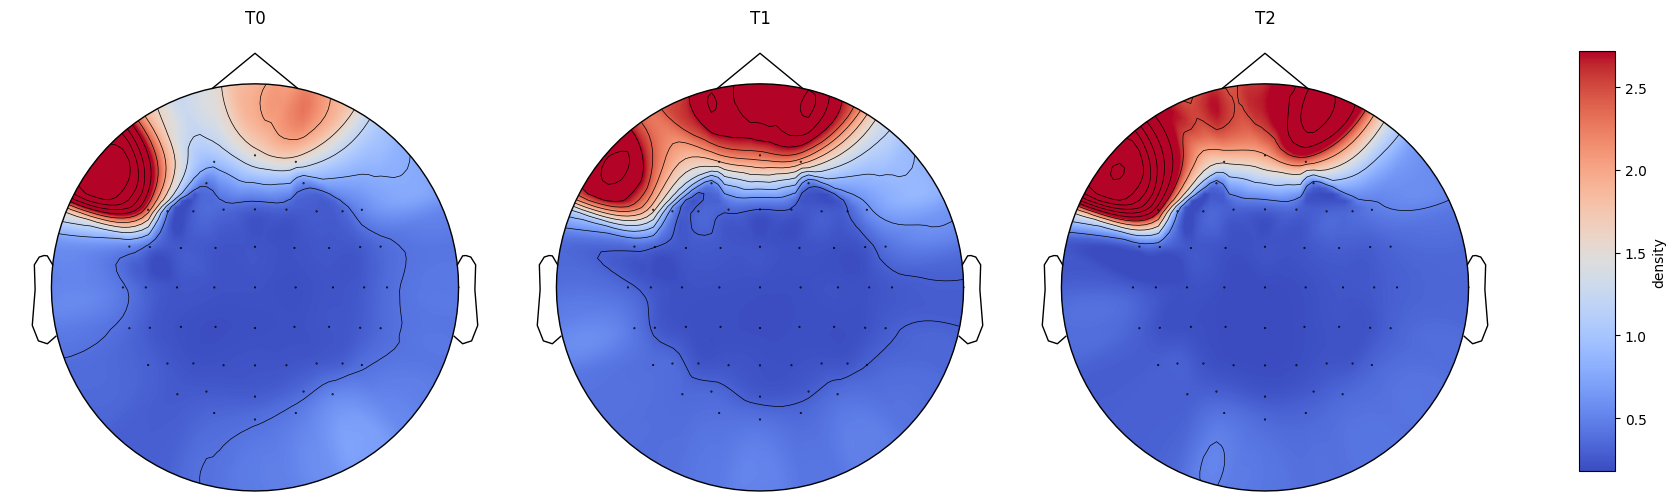

In [65]:
norm = Normalize(vmin=np.min(degrees_selected_chans), vmax=np.max(degrees_selected_chans))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
degree_arrays = [degrees_minmax[0], degrees_minmax[1], degrees_minmax[2]]
titles = ['T0', 'T1', 'T2']

# 循环绘制每个图
for i, (degree_array, ax) in enumerate(zip(degree_arrays, axes)):
    # 使用统一的颜色映射
    info = mne.create_info(ch_names=channel_name_list, sfreq=128., ch_types='eeg')
    evoked = mne.EvokedArray(degrees_selected_chans.T, info)
    evoked.set_montage(biosemi_montage)

    im, _ = mne.viz.plot_topomap(evoked.data[:, i], evoked.info, show=False, axes=ax,
                            ch_type='eeg', cmap='coolwarm', contours=10,vlim=(vmin, vmax), sphere=(0, 0, 0, 0.12))#vlim=(vmin, vmax),np.mean(evoked.data, axis=1)
    ax.set_title(titles[i])

# 在右侧添加一个共享的颜色条
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])

# 调整子图布局，确保colorbar不会与图片重叠
fig.subplots_adjust(right=0.85)  # 为colorbar预留空间，右侧留出15%的宽度

# 将 colorbar 放在右侧
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(sm, cax=cbar_ax, label="density")

# 调整布局并显示图像
plt.tight_layout(rect=[0, 0, 0.85, 1])  # 保证子图不被重叠
plt.savefig(f'topomap/fig-label{selec_lab}-{person}-{band}-2.pdf')
plt.show()

[[ 0  0  0 ... 93 94 95]
 [ 1  2  3 ... 93 94 95]]
(3, 32)
Creating RawArray with float64 data, n_channels=32, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


/tmp/ipykernel_1670172/2917170692.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # 保证子图不被重叠


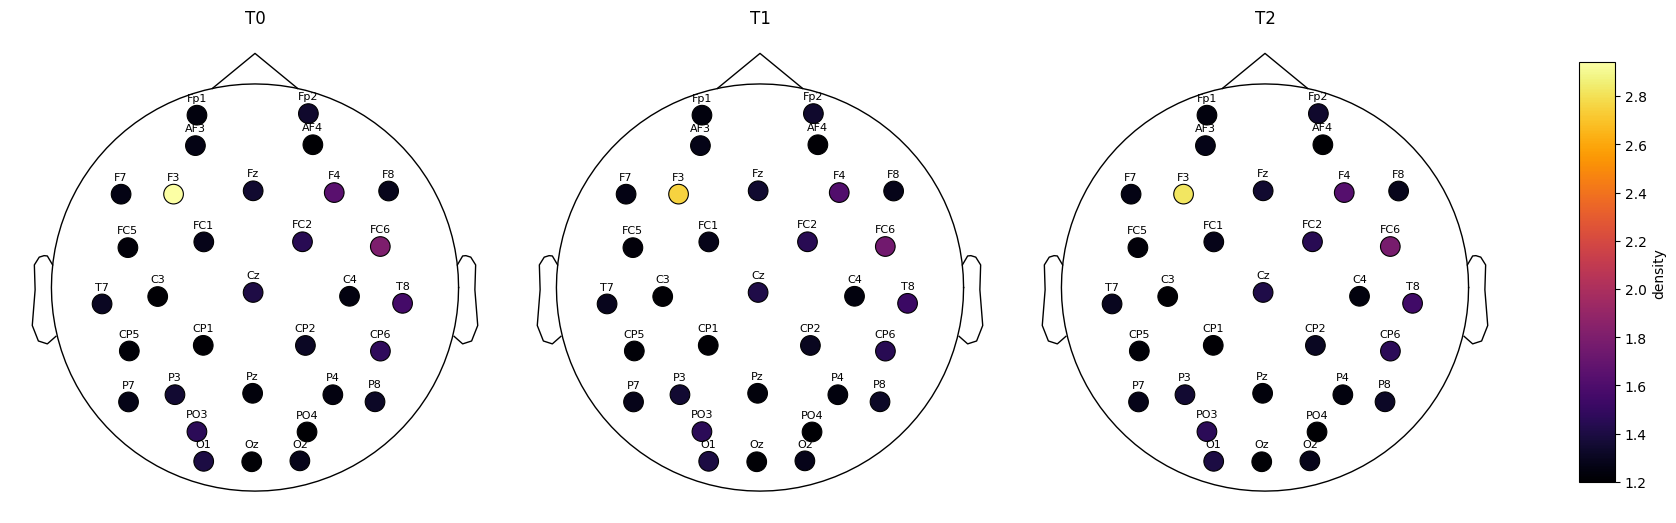

In [103]:
bands = ["alpha", "beta", "theta", "gamma", "de"]
selec_lab = 3
person = 's11'
# for band in bands:
band = "alpha"
cnt = 0
edge_index_np = None
attention_weights_np = None 
for n in range(211):
    attention_weights = torch.load(f'/data/Anaiis/garage/vis_data/{person}/attn_weight_l1{band}_{n}.pt')
    edge_index = torch.load(f'/data/Anaiis/garage/vis_data/{person}/edge_index_l1_{n}.pt')
    label = torch.load(f'/data/Anaiis/garage/vis_data/{person}/labels_{n}.pt').item()
    if label == selec_lab :
        # 将 edge_index 和 attention_weights 转换为 NumPy 数组
        if cnt == 0:
            edge_index_np = edge_index.cpu().numpy()
            attention_weights_np = attention_weights.cpu().numpy().squeeze()
            cnt += 1
            print(edge_index_np)
        else:
            attention_weights_np += attention_weights.cpu().numpy().squeeze()
num_nodes = edge_index_np.max() + 1  # 节点个数
adj_matrix = np.zeros((num_nodes, num_nodes))

for idx in range(edge_index_np.shape[1]):
    i, j = edge_index_np[:, idx]
    adj_matrix[i, j] = attention_weights_np[idx].mean()

degrees = adj_matrix.mean(axis = 1)

degrees = degrees.reshape((-1, 32))
print(degrees.shape)

montage = mne.channels.make_standard_montage('standard_1020')
channels = ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5',
    'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8',
    'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2',
    'Fz', 'Cz']
info = mne.create_info(ch_names=channels, sfreq=1, ch_types='eeg')
info.set_montage(montage)

data = np.zeros((32, 1))
raw = mne.io.RawArray(data, info)

norm = Normalize(vmin=np.min(degrees), vmax=np.max(degrees))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 定义三个时间点的 degree_array 和各自的 axes
degree_arrays = [degrees[0], degrees[1], degrees[2]]
titles = ['T0', 'T1', 'T2']

# 循环绘制每个图
for i, (degree_array, ax) in enumerate(zip(degree_arrays, axes)):
    # 使用统一的颜色映射
    raw.plot_sensors(ch_type="eeg", axes=ax, show=False)
    sensor_points = ax.collections[0]
    positions = sensor_points.get_offsets()

    positions[:, 1] -= 0.02  # 根据需要调整数值
    sensor_points.set_offsets(positions)
    # 设置颜色
    colors = [plt.cm.inferno(norm(degree_array[i])) for i in range(32)]
    sensor_points.set_facecolors(colors)
    sensor_points.set_edgecolors('k')
    sensor_points.set_linewidths(0.8)

    # 设置节点大小（加大点大小）
    sensor_points.set_sizes([200] * len(positions))  # 200 是调整后的大小，可以根据需要增减

    # 显示通道名称
    for j, ch_name in enumerate(channels):
        ax.text(positions[j, 0], positions[j, 1] + 0.008, ch_name, fontsize=8, ha='center', va='center')

    # 添加标题
    ax.set_title(titles[i])

# 在右侧添加一个共享的颜色条
sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
sm.set_array([])

# 调整子图布局，确保colorbar不会与图片重叠
fig.subplots_adjust(right=0.85)  # 为colorbar预留空间，右侧留出15%的宽度

# 将 colorbar 放在右侧
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(sm, cax=cbar_ax, label="density")

# 调整布局并显示图像
plt.tight_layout(rect=[0, 0, 0.85, 1])  # 保证子图不被重叠

plt.savefig(f'electron/fig-label{selec_lab}-{person}-{band}.pdf')
plt.show()